In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.registrationdata as regdata
import defmod.hamiltonian_multishape as hamiltonian
from defmod.energyfunctional import EnergyFunctional_unconstrained, EnergyFunctional
from defmod import optimize
import defmod.save_results as results



torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
data = regdata.Multi_Nuts()
data()
source = data.source
target = data.target

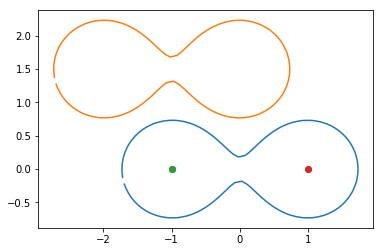

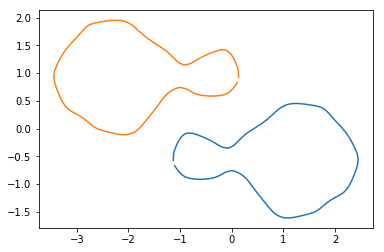

In [3]:
gd0 = [data.modules[i].manifold[1].gd.view(-1,2) for i in range(2)]
gd1 = [data.modules[i].manifold[2].gd.view(-1,2) for i in range(2)]

plt.figure()
for i in range(2):
    plt.plot(source[i].detach().numpy()[:,0], source[i].detach().numpy()[:,1])
    plt.scatter(gd0[i].detach().numpy()[:,0],gd0[i].detach().numpy()[:,1])
    plt.scatter(gd1[i].detach().numpy()[:,0],gd1[i].detach().numpy()[:,1])

plt.figure()
plt.plot(target[0].detach().numpy()[:,0], target[0].detach().numpy()[:,1])
plt.plot(target[1].detach().numpy()[:,0], target[1].detach().numpy()[:,1])

plt.show()

In [7]:
sigma_bg = 0.001
modules = dm.multishape.MultiShapeModule([data.modules[0]], sigma_bg)
constr = dm.constraints.Identity_Silent()
H = dm.hamiltonian_multishape.Hamiltonian_multi(modules, constr)
def attach(modules, target):
    return dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i][0].manifold.gd.view(-1,2) for i in range(1)], target)
E = EnergyFunctional_unconstrained(H.module, H, source, target, dim=2, gamma=0.01, attach=attach)

In [8]:
gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

from defmod import optimize
X[1] = optimize.BFGS(E, X, disp=True)(maxiter=100)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.0 attach: 12.933211334882209
cost: 0.0 attach: 12.933211334882209
cost: 0.04977896069746625 attach: 1.093302372364918e+43
cost: 0.04977896069746625 attach: 1.093302372364918e+43
cost: 0.005530995632617224 attach: 10.874408544687105
cost: 0.005530995632617224 attach: 10.874408544687105
cost: 0.030113198444249294 attach: 7.701616276705468e+38
cost: 0.030113198444249294 attach: 7.701616276705468e+38
cost: 0.011539978413250478 attach: 81.21089491548238
cost: 0.011539978413250478 attach: 81.21089491548238
cost: 0.005530997263123802 attach: 10.874296587096039
cost: 0.005530997263123802 attach: 10.874296587096039
cost: 0.005530997263785138 attach: 10.874381108801991
cost: 0.005530997263785138 attach: 10.874381108801991
cost: 0.005530997263123802 attach: 10.874296587096039
cost: 0.005530997263123802 attach: 10.874296587096039


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.04977896069746625 attach: 1.093302372364918e+43
cost: 0.012444740174366562 attach: 60068.83010392892
cost: 0.0055309956330518205 attach: 10.874491990199866
cost: 0.0055309956330518205 attach: 10.874491990199866
cost: 0.008642180676643445 attach: 10.466802377410476
cost: 0.008642180676643445 attach: 10.466802377410476
cost: 0.008642120574005421 attach: 10.460995667510629
cost: 0.008642120574005421 attach: 10.460995667510629
cost: 0.00864212048699422 attach: 10.464027811506297
cost: 0.00864212057400504 attach: 10.459001269088205
cost: 0.00864212057400504 attach: 10.459001269088205
cost: 0.00864212057400504 attach: 10.459001269088205
cost: 0.00864212057400504 attach: 10.459001269088205
cost: 0.00864212057400504 attach: 10.459001269088205
cost: 0.00864212057400504 attach: 10.459001269088205
cost: 0.00864212057400504 attach: 10.459001269088205
         Current function value: 12.933211
         Iterations: 0
         Function evaluations: 20
         Gradient evaluations: 12


../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)
../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


FileNotFoundError: [Errno 2] No such file or directory: '../results/Nuts-Multi/MultiShapeDefmod/shooting0.png'

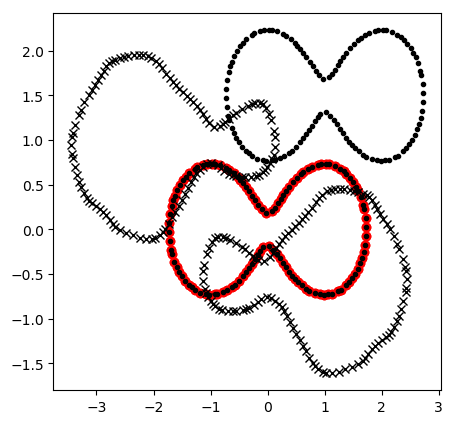

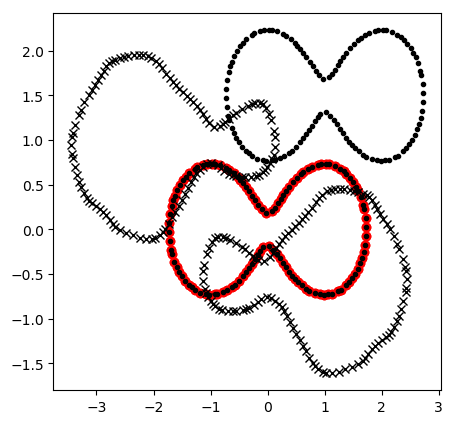

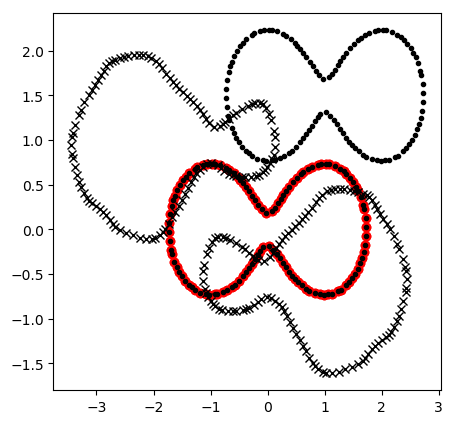

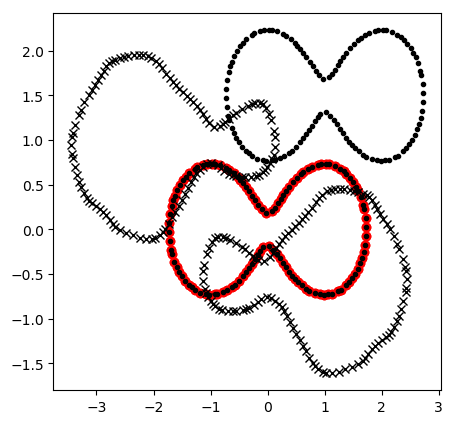

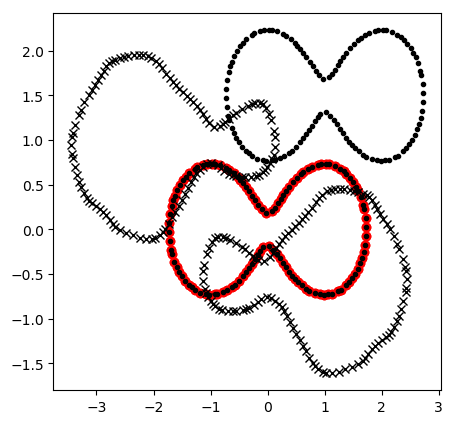

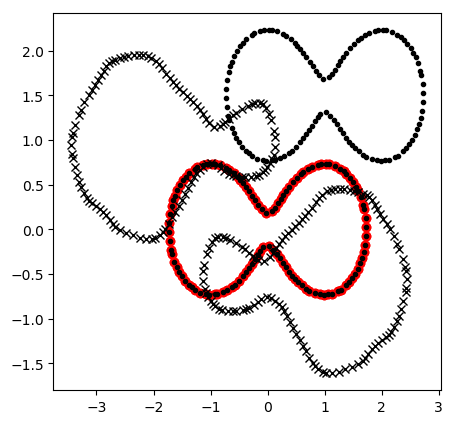

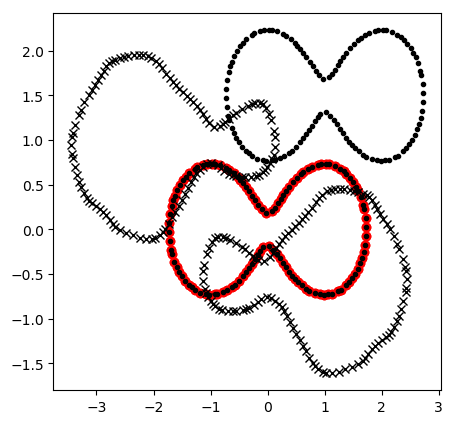

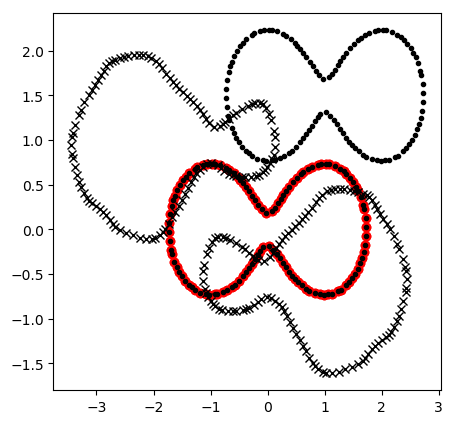

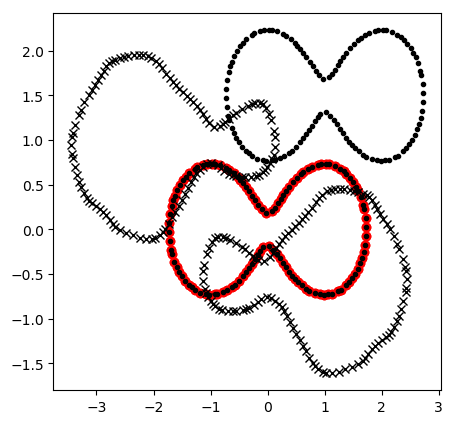

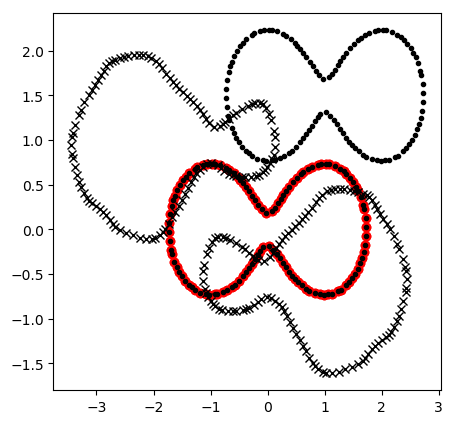

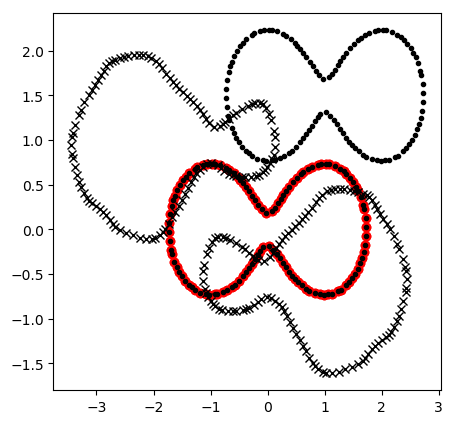

In [12]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()
save = results.Save_Results_MultiShape(H, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)

#fig_states = save.fig_states(show=True)
#fig_grid1, fig_grid2, fig_grid_bg, fig_multigrid = save.fig_grids(True)

save.save('../results/Nuts-Multi/MultiShapeDefmod/')
plt.close('all')

In [ ]:
## LDDMM Multishape Module
sigma1 = 2
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma2 = 2
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.5
multi_LDDMM = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H_multi_LDDMM = dm.hamiltonian_multishape.Hamiltonian_multi(multi_LDDMM, constr)

In [11]:
## LDDMM Module

man_compound = dm.manifold.Landmarks(2, len( torch.cat(source)), gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=0.5)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

def attach(modules, target):
    return dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[0].manifold.gd.view(-1,2)], target)

reg_param = 1e-3
Energy_LDDMM = EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


cost: 0.0 attach: 79.44780313739015
cost: 0.0 attach: 79.44780313739015
cost: 0.007617595968550955 attach: 90.95189181539146
cost: 0.007617595968550955 attach: 90.95189181539146
cost: 0.0015445168666838379 attach: 46.92856065805344
cost: 0.0015445168666838379 attach: 46.92856065805344
cost: 0.012723802229235439 attach: 221.3261199738241
cost: 0.012723802229235439 attach: 221.3261199738241
cost: 0.0019172741043709876 attach: 43.00100403179072
cost: 0.0019172741043709876 attach: 43.00100403179072
cost: 0.002770990287364195 attach: 38.13083172890843
cost: 0.002770990287364195 attach: 38.13083172890843
cost: 0.004364509977958402 attach: 32.985395607713386
cost: 0.004364509977958402 attach: 32.985395607713386
cost: 0.007144530070600038 attach: 32.01976461246579
cost: 0.007144530070600038 attach: 32.01976461246579
cost: 0.005261729828993734 attach: 29.984480816111716
cost: 0.005261729828993734 attach: 29.984480816111716
cost: 0.006962027781392943 attach: 30.443697711672332
cost: 0.0069620277

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


cost: 0.018181895108450506 attach: 15.925722858220304
cost: 0.01818189509588631 attach: 15.925722847583149
cost: 0.01818189509495857 attach: 15.925722899130246
cost: 0.018181895094495155 attach: 15.925722844660488
cost: 0.018181895094262924 attach: 15.925722845496033
cost: 0.018181895094146878 attach: 15.925722838003164
cost: 0.018181895094088758 attach: 15.925722836240801
cost: 0.018181895094059996 attach: 15.925722843950478
cost: 0.018181895094045525 attach: 15.925722848361108
cost: 0.01818189509403814 attach: 15.925720769789148
cost: 0.01818189509403814 attach: 15.925720769789148
cost: 0.01818189509403799 attach: 15.92572284478494
cost: 0.01818189509403814 attach: 15.925720769789148
         Current function value: 15.943905
         Iterations: 19
         Function evaluations: 90
         Gradient evaluations: 79


In [12]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
#save.fig_grid(True)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


In [ ]:
save.save('../results/circles_translation/LDDMM/')
plt.close('all')

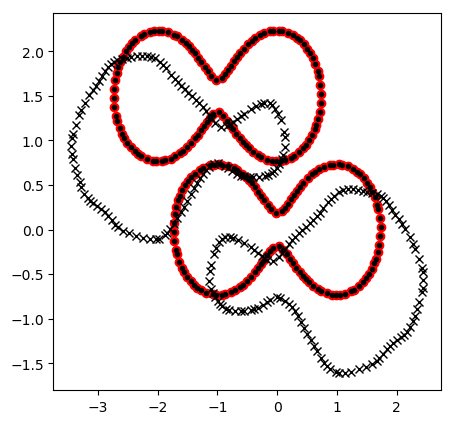

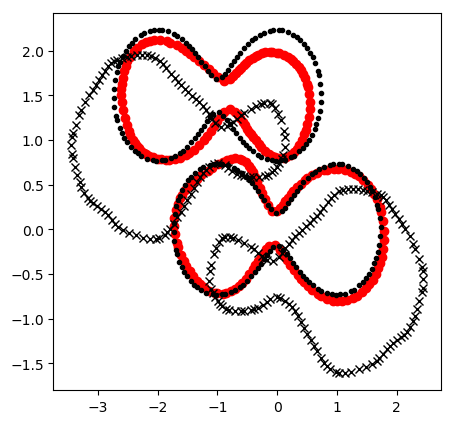

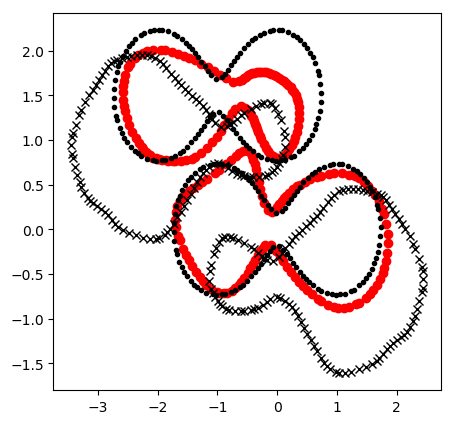

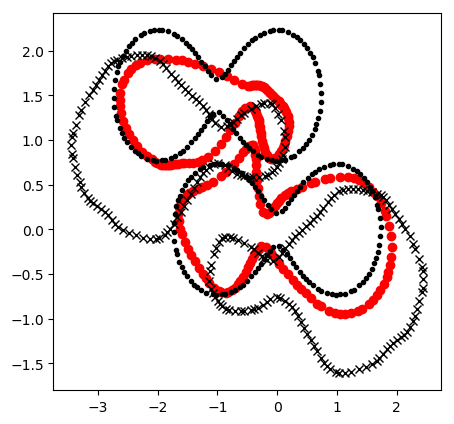

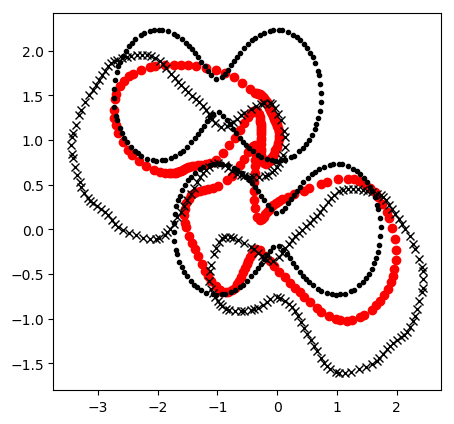

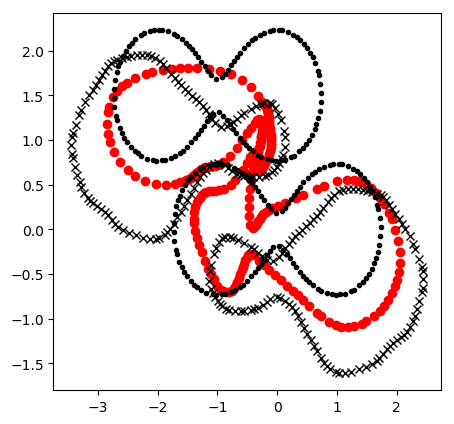

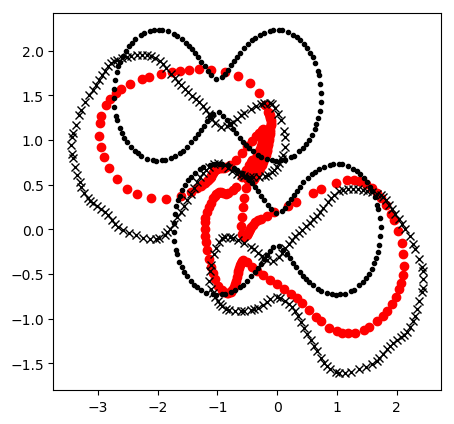

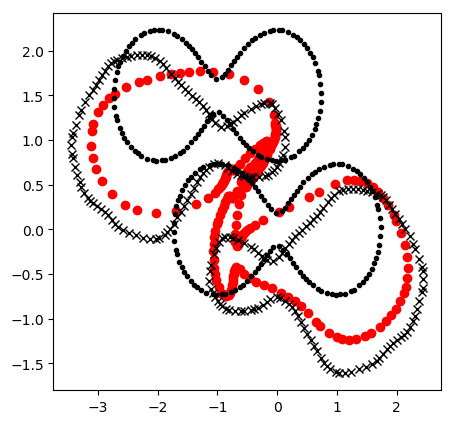

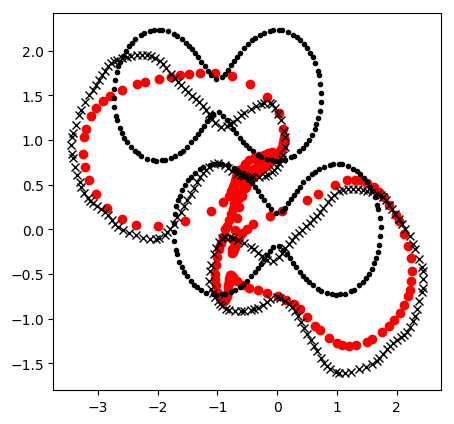

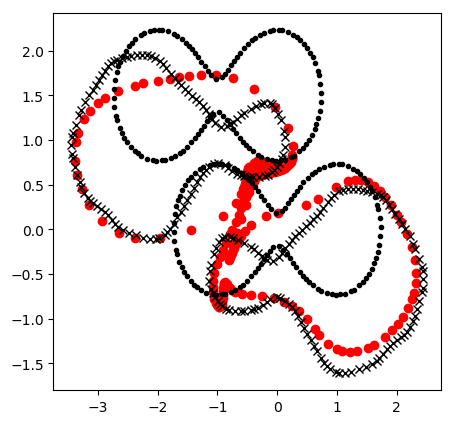

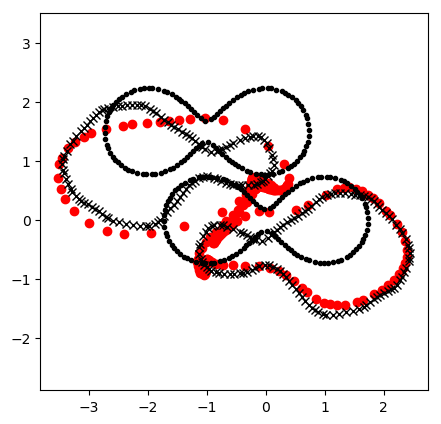

[<Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>,
 <Figure size 500x500 with 1 Axes>]

In [13]:
save.fig_states(True)

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd().copy()).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan().copy()).requires_grad_().view(-1)


test_gradcheck_Hamiltonian()